In [2]:
import pygmt
import os
import pandas as pd
import numpy as np

## 計算相對運動的函數
此計算可參考課本21頁的範例  
主要是給定 計算點的座標＆pole的座標＆angular frequency  
就可以得出計算點的板塊相對移動速度以及其方位角beta  
變數的命名都和課本一樣  
單位請注意

In [3]:
def relative_motion(lambda_x, lambda_p, phi_x, phi_p, omega):
    #########################################################
    # We can use this function to calculate the relative 
    # motion of the specific plate.
    # Please note the unit of each parameter!
    # lambda_x, lambda_p, phi_x, phi_p are in degree
    # omega -> [degree/year]
    # It refer to the example from textbook p.21
    #########################################################
    radius = 6371. * 1e+05              # From [km] to [cm] 
    lambda_x = np.deg2rad(lambda_x)
    lambda_p = np.deg2rad(lambda_p)
    phi_x = np.deg2rad(phi_x)
    phi_p = np.deg2rad(phi_p)
    omega = np.deg2rad(omega)

    angle_a = np.arccos(np.sin(lambda_x)*np.sin(lambda_p)\
        +np.cos(lambda_x)*np.cos(lambda_p)*np.cos(phi_p-phi_x))
    
    angle_C = np.arcsin(np.cos(lambda_p) * np.sin(phi_p-phi_x) / np.sin(angle_a))
    velocity = omega * radius * np.sin(angle_a)
    angle_C = np.rad2deg(angle_C)
    beta = 90 + angle_C
    return angle_C, velocity, beta

## 讀取板塊邊界資料的函數
此三函數的功能依序為：
### read_the_boundary_file
讀進邊界資料的檔案，傳回整個檔案中的資料
### find_the_header
因為檔案中有許多段板塊邊界，若是一起畫可能會整連在一起，所以希望能夠找出每一段的開頭，進而在接下來的函數中將資料分割成好幾段。  
(我記得在GMT中可以整個檔案直接讀進去畫，它會自己判斷斷開的地方要分開來畫，但我不確定pygmt可否，所以還是先主動分開)
### get_data_for_each_plate_boundary
此函數利用上個函數所找到每一段邊界的開頭以及結尾，來讀取每一段邊界的資料點，並回傳兩個list，分別為經度以及緯度的list

In [4]:
def read_the_boundary_file(file_for_reading):
    f = open(file_for_reading, 'r')
    data = f.readlines()
    f.close()
    return data

def find_the_header(data):
    header_index = []
    for ii, line in enumerate(data):
        if line[:3] == '***':
            header_index.append(ii)
    return header_index

def get_data_for_each_plate_boundary(data, line1, line2):
    lon_list, lat_list = [], []
    for line in data[line1:line2]:
        line = line.strip()
        info = line.split(',')
        lon, lat = float(info[0]), float(info[1])
        lon_list.append(lon)
        lat_list.append(lat)
    return lon_list, lat_list

## 指定作圖區域以及下載地形網格檔
這裡可以指定你要作圖的區域，以你們的作業來說應該要畫全球的。
第二行中是下載地形檔案，讓你的圖可以疊上地形起伏，resolution為01m的意思是此網格檔下載下來是每一格1分(arc-minute)，  
這主要是給我畫台灣附近的尺度的，如果你們要畫全球尺度我自己覺得20或30m應該就足夠了，  
檔案太大你會下載到哭。

In [5]:
region = [118, 127, 20, 26]
grid = pygmt.datasets.load_earth_relief(resolution='01m', region=region)

## 建立底圖
這裡主要是建立你的畫框  
第二行是利用你剛剛下載的地形檔案(grid)來畫地形，'M6i'代表的是：利用麥卡托投影將地圖投影在寬度6英吋的地圖上
第三行是畫海岸線，詳細參數麻煩各位自行查閱，主要就是調整粗細等等。

In [6]:
fig = pygmt.Figure()
fig.grdimage(grid, region=region, projection='M6i', cmap='ETOPO1.cpt')
fig.coast(region=region, projection="M6i",
            shorelines=['0.2p', 'black'], frame=['a2f0.5', 'WSne'], area_thresh=0.1)

## 讀取資料及畫板塊邊界
這裡就是針對邊界檔案PB2002_boundaries.dig.txt做一些操作，
有興趣的再看就好，可以自己研究一下邊界檔案裡面的資料長怎樣。  
沒興趣的就跳過，  
有搭配上方一些自己寫的函數來使用。

In [7]:
data = read_the_boundary_file('PB2002_boundaries.dig.txt')
header_index = find_the_header(data)
for ii, segment in enumerate(header_index):
    if ii == 0:
        line1 = 1
        line2 = segment
    else:
        line1 = line2+2
        line2 = segment
    lon_list, lat_list = get_data_for_each_plate_boundary(data, line1, line2)
    boundary_df = pd.DataFrame(zip(lon_list, lat_list), columns=['lon', 'lat'])
    fig.plot(x=boundary_df.lon, y=boundary_df.lat, pen="0.8p,red") 


## 建立計算點座標
此步驟我僅是隨意取三點來當我要計算的點，
你們要計算的點都有課本習題上指定，只要將其輸入進去即可，  
最後一行是將計算點座標畫上圓點

In [8]:
sample_points_lon, sample_points_lat = [122, 123, 124], [22, 22, 22]
sample_points_df = pd.DataFrame(zip(sample_points_lon, sample_points_lat), columns=['lon', 'lat'])
fig.plot(x=sample_points_df.lon, y=sample_points_df.lat, style="c0.1c", color='red', pen="black")

## 計算相對移動速度及其方位角
要注意你們要計算的每一個點不見得會在相同的板塊相對關係上  
我這裡僅考慮到菲律賓海板塊相對於歐亞板塊  
你們要想辦法找出每一個點落在哪些板塊上，然後才計算， 
或許也是要利用list或array去建立相對應的參數（e.g.每一點所對應到的pole參數以及angular frequency）

！！note！！
請注意由於我計算的pole資訊是’EU-PH’(參考下圖)
所以這裡計算出來的beta是歐亞板塊基於菲律賓海板塊的移動速度，
但我的點卻都座落在菲律賓海板塊上，我想描述的應該是菲律賓海板塊相對於歐亞板塊的速度，
所以我必須做角度上的轉換（360-beta）
這點你們要不要做完全取決於計算點的位置以及pole的相對關係
你們要自己判斷一下。

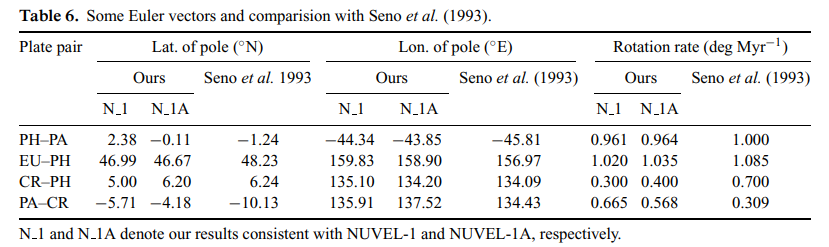

In [9]:
angle_C, velocity, beta = relative_motion(lambda_x=sample_points_df.lon,
                                          lambda_p=158.9, 
                                          phi_x=sample_points_df.lat, 
                                          phi_p=46.67, 
                                          omega=1.035e-06)
beta = 360 - beta

## 畫速度箭頭
這裡先將剛剛計算的速度投影至正北正東上（是為了符合下方的作圖參數）  
下方先建立一個dataframe來紀錄所要畫的資料，
其中的參數應該都看得懂，然後由於沒有要畫誤差橢圓（不知道是什麼就不用管）  
所以我將下方三個參數都設為０  
fig.velo就是利用剛剛建立的df畫箭頭的參數

In [10]:
vec_N = velocity * np.cos(np.deg2rad(beta))
vec_E = velocity * np.sin(np.deg2rad(beta))

points_num = len(sample_points_df)
df = pd.DataFrame(
    data={
        "x": sample_points_df.lon,
        "y": sample_points_df.lat,
        "east_velocity": vec_E,
        "north_velocity": vec_N,
        "east_sigma": np.zeros(points_num),
        "north_sigma": np.zeros(points_num),
        "correlation_EN": np.zeros(points_num)
    }
)
fig.velo(
    data=df,
    pen="1p,black",
    spec="e0.2/0",
    color='red'
)

## 畫範例箭頭
畢竟只畫箭頭別人根本不知道什麼長度對應到什麼樣的相對移動速度，  
所以必須畫個範例的箭頭並且告訴大家這長度代表的速度值，  
我只是重複上方的操作來畫，  
可以自己再美化一下。

In [11]:
# Here we plot the reference arrow with 7.5 cm/yr
df_ex = pd.DataFrame(
    data={
        "x": [120],
        "y": [21.1],
        "east_velocity": [-7.5],
        "north_velocity": [0],
        "east_sigma": [0],
        "north_sigma": [0],
        "correlation_EN": [0]
    }
)
fig.velo(
    data=df_ex,
    pen="1p,black",
    spec="e0.2/0",
    color='red'
)
# Plot the text as label
fig.text(x=124.5, y=21.5, text='Philippine Sea Plate', font='18p,Helvetica-Bold,black')
fig.text(x=119.5, y=25, text='Eurasian Plate', font='18p,Helvetica-Bold,black')
fig.text(x=119.5, y=20.85, text='7.5 cm/yr', font='10p')

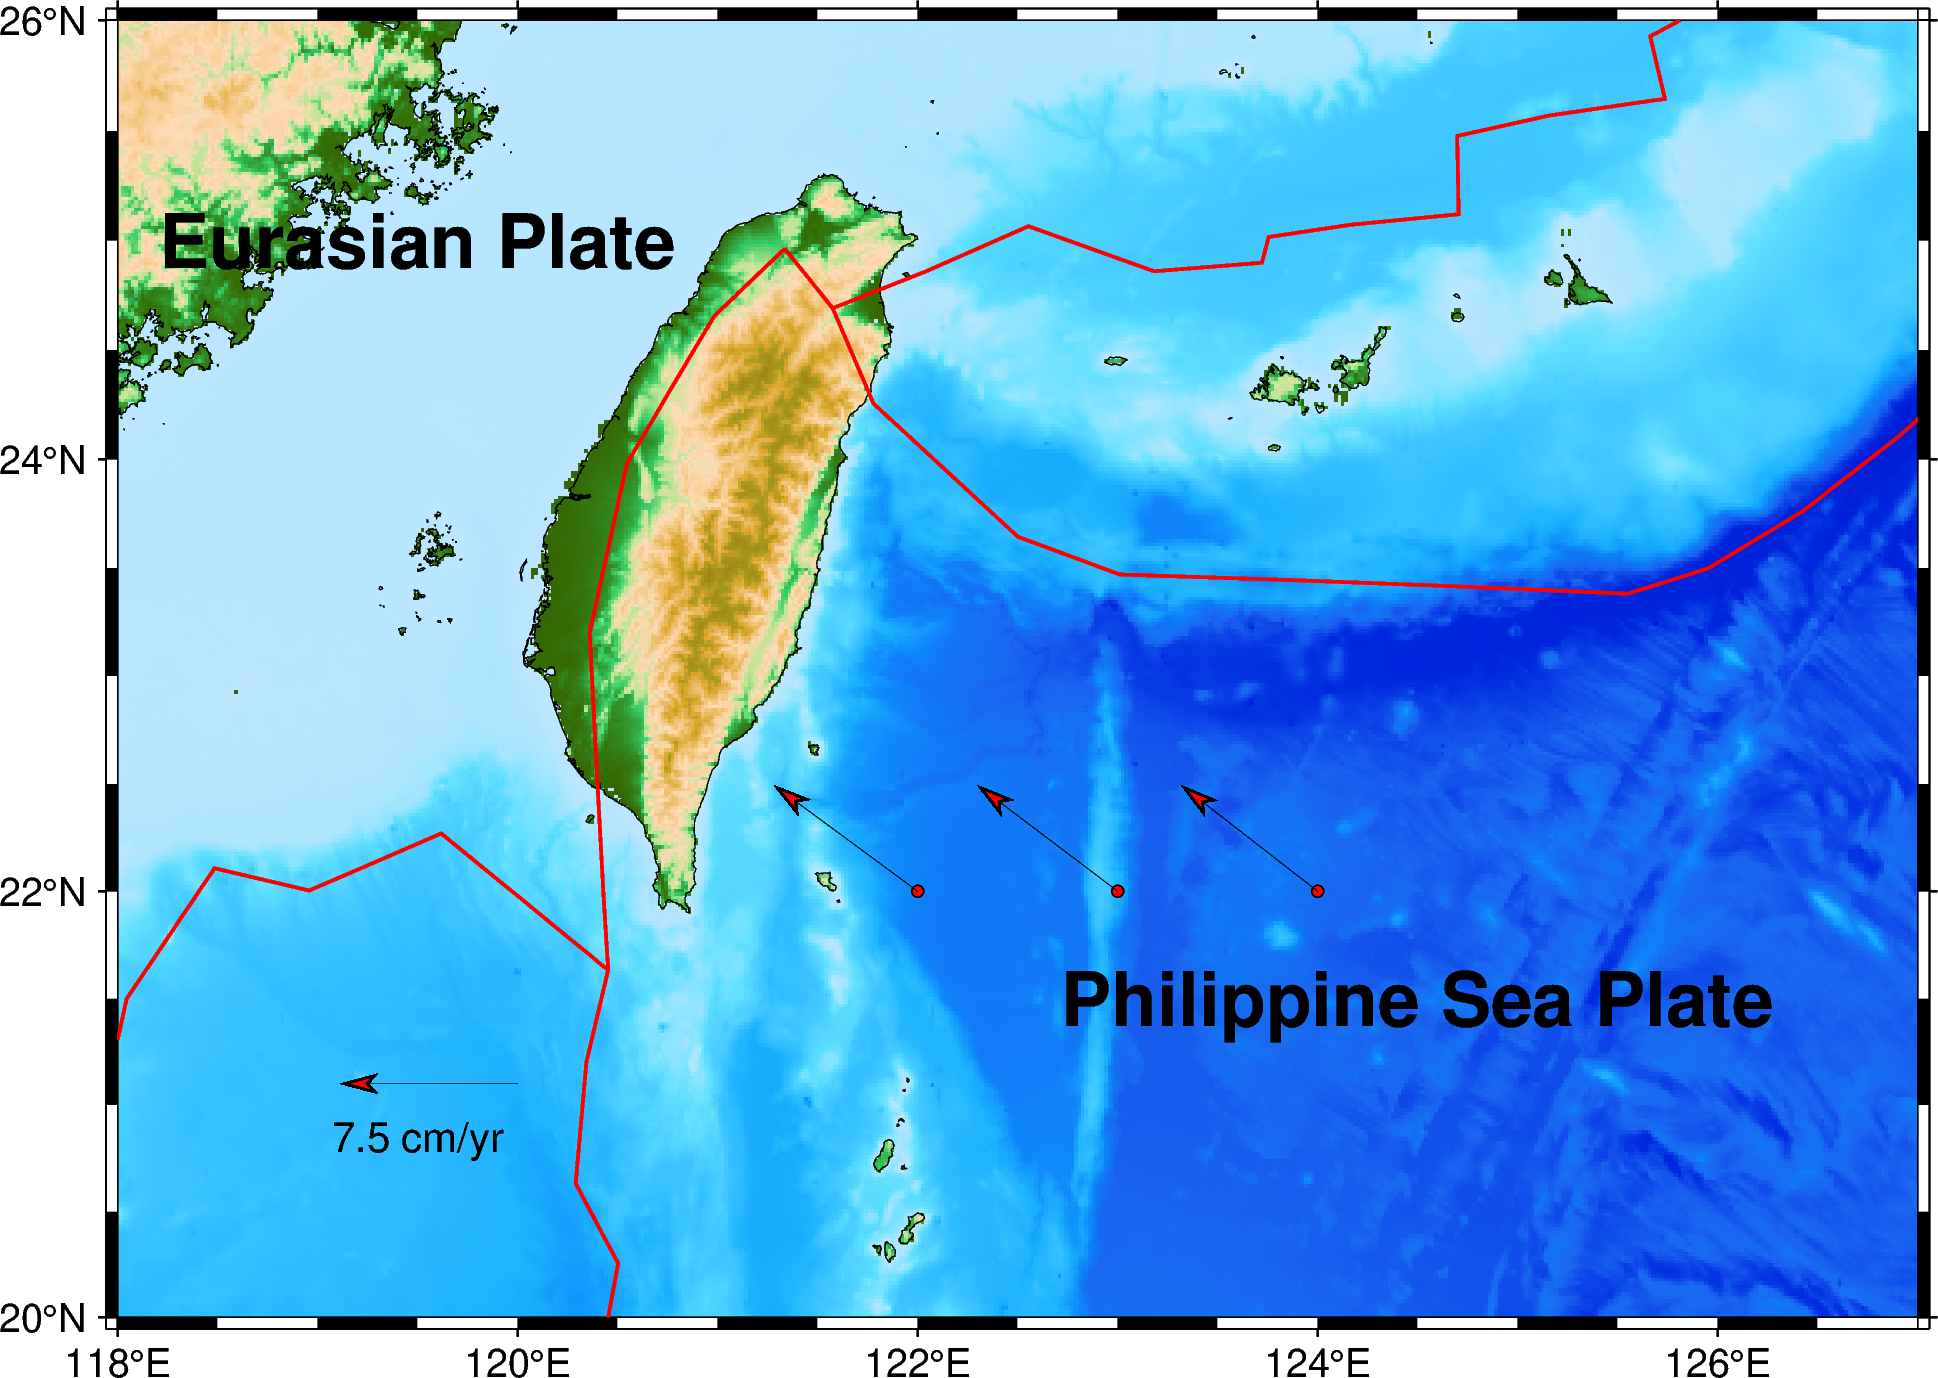

In [12]:
fig.show()
fig.savefig('Taiwan.png')

這樣一張簡單的地圖就能出來了，  
這當然只是很陽春的版本，  
鼓勵各位多花點時間美化～